# Phenomenological Synaptic Models

In [1]:
%reset -f
import numpy as np
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### COBA

Given the synaptic conductance, the COBA model outputs the post-synaptic current with

$$
I_{syn}(t) = g_{\mathrm{syn}}(t) (E - V(t))
$$


### CUBA

Given the conductance, this model outputs the post-synaptic current with a identity function:

$$
I_{\mathrm{syn}}(t) = g_{\mathrm{syn}}(t)
$$

## ``brainpy.dyn.ProjAlignPreMg2``

Synaptic projection which defines the synaptic computation with the dimension of presynaptic neuron group.


```
brainpy.dyn.ProjAlignPreMg2(
   pre, 
   delay,
   syn,  
   comm, 
   out, 
   post
)
```

- ``pre (JointType[DynamicalSystem, AutoDelaySupp])``: The pre-synaptic neuron group.
- ``delay (Union[None, int, float])``: The synaptic delay.
- ``syn (ParamDescInit)``: The synaptic dynamics.
- ``comm (DynamicalSystem)``: The synaptic communication.
- ``out (ParamDescInit)``: The synaptic output.
- ``post (DynamicalSystem)`` The post-synaptic neuron group.


![](figs/align_pre.png)


## Dual Exponential Model

The dual exponential synapse model, also named as *difference of two exponentials model*, is given by:

$$
g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} \frac{\tau_{1} \tau_{2}}{\tau_{1}-\tau_{2}}\left(\exp \left(-\frac{t-t_{0}}{\tau_{1}}\right)-\exp \left(-\frac{t-t_{0}}{\tau_{2}}\right)\right)
$$

where $\tau_1$ is the time constant of the decay phase, $\tau_2$ is the time constant of the rise phase, $t_0$ is the time of the pre-synaptic spike, $\bar{g}_{\mathrm{syn}}$ is the maximal conductance.

The corresponding differential equation:

$$
\begin{aligned}
&g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} g \\
&\frac{d g}{d t}=-\frac{g}{\tau_{\mathrm{decay}}}+h \\
&\frac{d h}{d t}=-\frac{h}{\tau_{\text {rise }}}+ \delta\left(t_{0}-t\right),
\end{aligned}
$$

The alpha function is retrieved in the limit when both time constants are equal.

# Syt2 KO influence for dynamics

t rise 表示突触受体通道从关闭到开放的速度，即突触电导开始上升的快慢<br>
t decay 表示突触电导从峰值恢复到基线的速度，即受体失活或通道关闭的快慢

gmax 变小 <br>
蛋白减少 → 囊泡释放减少 → 神经递质浓度降低 → 受体激活数减少 → g<sub>max 下降

gmax影响因素 <br>
1. 释放的神经递质浓度
2. 突触后受体激活的数量 <br>

t decay 小幅度变小 <br>
如果释放的神经递质量减少 → 激活受体的数量少 → 清除更快 → 电导更快衰减

t decay影响因素
1. 受体解离速率
2. 神经递质清除速率
3. 受体去激活动力学
4. 离子通道关闭、再激活前的恢复时间

t rise 大幅度增大 <br>
释放的神经递质更少 → 达到足够激活受体的浓度时间更长 <br>
电导曲线上升坡变缓

t rise 影响因素
1. 神经递质在突触间隙扩散的速度
2. 结合受体的速度
3. 触发受体开放的速度

# VN -> CbX

In [2]:
duration = 10 # unit s

Synapse: Dual Exponential

In [3]:
class DualExpSparseCOBA(bp.Projection):
  def __init__(self, pre, post, delay, prob, g_max, tau_decay, tau_rise, E):
    super().__init__()
    
    self.proj = bp.dyn.ProjAlignPreMg2(
      pre=pre, 
      delay=delay, 
      syn=bp.dyn.DualExpon.desc(pre.num, tau_decay=tau_decay, tau_rise=tau_rise),
      comm=bp.dnn.CSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
      out=bp.dyn.COBA(E=E),
      post=post, 
    )

In [4]:
def run_a_net_plot(net):
  #indices = np.arange(1900) # for single spike 100ms
  indices = np.arange(duration*10000)   # for spike train
  conductances, currents, potentials = bm.for_loop(net.step_run, indices, progress_bar=True)
  ts = indices * bm.get_dt()
  
  # --- similar to: 
  # runner = bp.DSRunner(net)
  # conductances, currents, potentials = runner.run(100.)
  
  fig, gs = bp.visualize.get_figure(1, 3, 3.5, 4)
  fig.add_subplot(gs[0, 0])
  plt.plot(ts, conductances)
  plt.title('Syn conductance')
  fig.add_subplot(gs[0, 1])
  plt.plot(ts, currents)
  plt.title('Syn current')
  fig.add_subplot(gs[0, 2])
  plt.plot(ts, potentials)
  plt.title('Post V')
  plt.show()
  return potentials

In [5]:
def run_a_net(net):
  indices = np.arange(duration*10000)   # for spike train
  conductances, currents, potentials = bm.for_loop(net.step_run, indices, progress_bar=True)
  ts = indices * bm.get_dt()
  return potentials

In [6]:
def Poisson_sptrain(fr):
    n = np.random.poisson(fr * duration)  # 计算时间段T内的事件总数（泊松分布）
    spike_times = np.sort(np.random.uniform(0, duration, n))  # 在[0,T]内均匀生成n个事件时间点并排序
    spike_times = spike_times * 1000  # unit ms
    isi = np.diff(spike_times)  # 计算事件间隔时间（Inter-Spike Interval）unit ms
    return spike_times, isi  # 返回事件时间序列和间隔序列

In [7]:
def find_trig_spike_time(arr):
    #找到所有满足前值 > -50.8 且后值 = -60 的连续元素对
    mask = (arr[:-1] > -50.8) & (arr[1:] == -60) # 通过切片操作，隐式比较了每一对相邻元素
    indices = np.where(mask)[0] / 10  # 换算为ms
    return indices

def plot_isi(isi,name,cutoff_distr):
    isi = isi[(isi > 0.001) & (isi <= cutoff_distr)]
    plt.figure(figsize=(10, 4))
    plt.hist(isi, bins=100, color='dodgerblue', alpha=0.7)
    plt.xlabel('Inter-spike Interval (ms)')
    plt.ylabel('Counts')
    plt.title(f'{name} ISI Distribution')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def Plot_SpikeTrain(input_sptimes,output_sptimes,input_name,output_name):
    plt.figure(figsize=(45, 2))
    plt.eventplot([input_sptimes, output_sptimes], colors=['b', 'r'], lineoffsets=[2, 1], linelengths=0.8)
    plt.yticks([1, 2], [f'{output_name}', f'{input_name}s'])
    plt.xlabel('Time (ms)')
    plt.title('Raster Plot of Input and Output Spike Times')
    plt.tight_layout()
    plt.show()

4 Syt2KO VN neuron -> 1 Granule cell

1. Input: Four VN neurons Poisson Process spike train

In [8]:
def generate_VNs_sptrain(VN_neuron_num,fr):
    all_events = []  # 格式：(spike_time, neuron_id)
    for j in range(VN_neuron_num):
        sptimes, isi = Poisson_sptrain(fr)  # input_sptimes unit ms
        # 为当前神经元的每个发放时间添加事件
        for t in sptimes:
            all_events.append((t, j))

    # 按发放时间排序
    all_events.sort(key=lambda x: x[0])  # 根据spike_time排序

    # 提取排序后的发放时间和对应神经元ID
    VNs_times = [event[0] for event in all_events]
    VNs_cluster = [event[1] for event in all_events]
    return VNs_times, VNs_cluster

2. Network: VN -> Granule cell Net

In [12]:
# Spike Train -> Synapse -> LIF
class VN_Gc_Net(bp.DynSysGroup):  
  def __init__(self, E=0.,freqs=30.):
    super().__init__()
    self.pre = bp.dyn.PoissonGroup(4, freqs=freqs)
    #self.pre = bp.dyn.SpikeTimeGroup(1, indices=(0, 0), times=(0., 100.))  # single spike input
    #self.pre = bp.dyn.SpikeTimeGroup(4, times=sptimes, indices=spcluster)  # spike train input
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    '''
    # 默认 normal
    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., g_max=1., 
                                tau_rise=1., tau_decay=5., E=E)  
    '''
    # Syt2 KO 上升更慢  衰减更快（囊泡释放更慢）  峰值更低g_max降低(囊泡释放更少)
    # V1 gmax' = 1/10gmax = 0.1, V2 gmax' = 0.2, V3 gmax' = 0.3
    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., 
                                tau_rise=25., tau_decay=2., g_max=0.2, E=E)  
    '''
    # junqiang parameters 会让postV产生波形抖动 符合patch结果
    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., 
                                tau_rise=20., tau_decay=0.5, g_max=0.5, E=E)
    
    # Syt2 overexpression 上升更快  衰减也更快（囊泡释放更快）  峰值更高(囊泡释放增加)
    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., 
                                tau_rise=0.5, tau_decay=3., g_max=1.9, E=E)   
    '''
  def update(self):
    self.pre()
    self.syn()
    self.post()
    
    # monitor the following variables
    conductance = self.syn.proj.refs['syn'].g
    current = self.post.sum_inputs(self.post.V)
    return conductance, current, self.post.V

3. Output: Granule cell spike times

In [13]:
def generate_1gc_sptrain():
    #VNs_times, VNs_cluster = generate_VNs_sptrain(VN_neuron_num = 2,fr = 15) #假设 4个granule cell有两个来自VN，发放率30
    GC_PostV = run_a_net(VN_Gc_Net(E=0.))  # Excitatory DualExpon synapse model
    GC_PostV_value = GC_PostV.value.flatten()  # 获取 Array 对象
    GC_sptimes = find_trig_spike_time(GC_PostV_value)  # unit ms
    GC_isi = np.diff(GC_sptimes)
    return GC_sptimes, GC_isi

GC_sptimes, GC_isi = generate_1gc_sptrain()

/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPreMg2 is deprecated. Use brainpy.dyn.FullProjAlignPreDSMg instead.
  _deprecate(message)
  0%|          | 0/100000 [00:00<?, ?it/s]/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/jax/extend/linear_util.py:38: DeprecationWarning: linear_util.wrap_init is missing a DebugInfo object. This behavior is deprecated, use api_util.debug_info() to construct a proper DebugInfo object and propagate it to this function. See https://github.com/jax-ml/jax/issues/26480 for more details.
  debug_info = debug_info or _missing_debug_info("linear_util.wrap_init")
/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/brainpy/_src/mixin.py:489: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', 

In [ ]:
Plot_SpikeTrain(VN_sptimes,GC_sptimes,'VN','GC')

firing rate of GC neuron:83.5


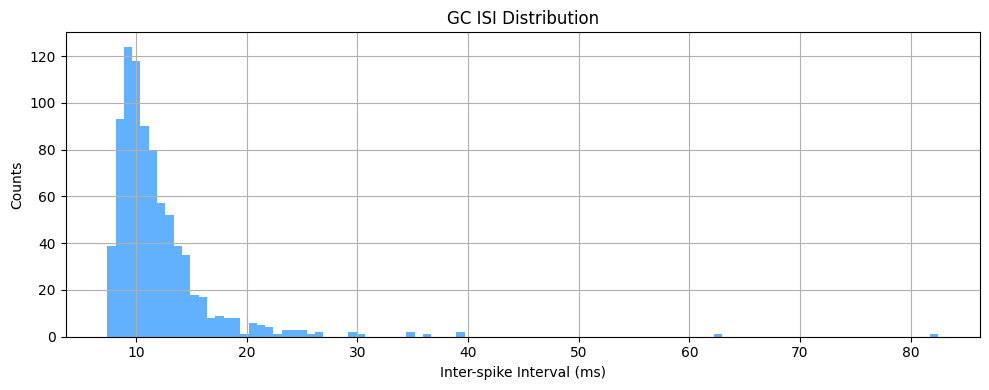

In [14]:
print(f"firing rate of GC neuron:{len(GC_sptimes)/duration}")
plot_isi(GC_isi,'GC',100)  #尽量让这个分布密度密一些，峰值更大一些，峰更靠右一些

5 Granule cell -> 1 Purkinje Cell<br>  Not all granule cells firing, although one PC receive 17500 Granule cells

1. Input: 5 syt2ko granule cells spike times

In [15]:
# Because Granule cell layer are so big, with the Syt2KO, they are more likely to synchrous to generate volley.
# There's no need to simulate 175,000 granule cells, just use one GC adding some jitter copying 20 GCs

def generate_gcs_sptrain():
    GC_neuron_num = 20
    jitter_window = 5  # ms

    all_events = []  # 格式：(spike_time, neuron_id)
    for i in range(GC_neuron_num):
        # 对于每个神经元，在每个 gamma spike 时间 t 加入一个 [0,10]ms 的 jitter
        jittered_spike_times = GC_sptimes + np.random.uniform(0, jitter_window, size=GC_sptimes.shape)
        # 为当前神经元的每个发放时间添加事件
        for t in jittered_spike_times:
            all_events.append((t, i))  # 记录(时间, 神经元ID)

    # 按发放时间排序
    all_events.sort(key=lambda x: x[0])  # 根据spike_time排序

    # 提取排序后的发放时间和对应神经元ID
    GCs_spike_times = [event[0] for event in all_events]
    GCs_spike_cluster = [event[1] for event in all_events]
    return GCs_spike_times,GCs_spike_cluster

'''
def generate_gcs_sptrain():
    GC_neuron_num = 20
    all_events = []  # 格式：(spike_time, neuron_id)

    for i in range(GC_neuron_num):
        GC_sptimes, GC_isi = generate_1gc_sptrain()

        # 为当前神经元的每个发放时间添加事件
        for t in GC_sptimes:
            all_events.append((t, i))  # 记录(时间, 神经元ID)

    # 按发放时间排序
    all_events.sort(key=lambda x: x[0])  # 根据spike_time排序

    # 提取排序后的发放时间和对应神经元ID
    GCs_spike_times = [event[0] for event in all_events]
    GCs_spike_cluster = [event[1] for event in all_events]
    return GCs_spike_times,GCs_spike_cluster
'''

'\ndef generate_gcs_sptrain():\n    GC_neuron_num = 20\n    all_events = []  # 格式：(spike_time, neuron_id)\n\n    for i in range(GC_neuron_num):\n        GC_sptimes, GC_isi = generate_1gc_sptrain()\n\n        # 为当前神经元的每个发放时间添加事件\n        for t in GC_sptimes:\n            all_events.append((t, i))  # 记录(时间, 神经元ID)\n\n    # 按发放时间排序\n    all_events.sort(key=lambda x: x[0])  # 根据spike_time排序\n\n    # 提取排序后的发放时间和对应神经元ID\n    GCs_spike_times = [event[0] for event in all_events]\n    GCs_spike_cluster = [event[1] for event in all_events]\n    return GCs_spike_times,GCs_spike_cluster\n'

2.  Network: Granule cell -> Purkinje cell

In [16]:
class Gc_Pc_Net(bp.DynSysGroup):
  def __init__(self,sptimes,spcluster, E=0.):
    super().__init__()
    # times is spike times of each spike, indices is unit id of each spike
    self.pre = bp.dyn.SpikeTimeGroup(5, times=sptimes, indices=spcluster)  # spike train input
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., g_max=1., 
                                 tau_decay=5., tau_rise=1., E=E)             
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    # monitor the following variables
    conductance = self.syn.proj.refs['syn'].g
    current = self.post.sum_inputs(self.post.V)
    return conductance, current, self.post.V

3. Output: Purkinje cell spike times

In [17]:
def generate_1pc_sptrain():
    GCs_spike_times, GCs_spike_cluster = generate_gcs_sptrain()
    PC_PostV = run_a_net(Gc_Pc_Net(sptimes = GCs_spike_times, spcluster = GCs_spike_cluster, E=0.)) # Excitatory DualExpon synapse model
    PC_PostV_value = PC_PostV.value.flatten()  # 获取 Array 对象
    PC_sptimes = find_trig_spike_time(PC_PostV_value)  # unit ms
    PC_isi = np.diff(PC_sptimes)
    return PC_sptimes,PC_isi

PC_sptimes, PC_isi = generate_1pc_sptrain()

/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPreMg2 is deprecated. Use brainpy.dyn.FullProjAlignPreDSMg instead.
  _deprecate(message)
  0%|          | 0/100000 [00:00<?, ?it/s]/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/jax/extend/linear_util.py:38: DeprecationWarning: linear_util.wrap_init is missing a DebugInfo object. This behavior is deprecated, use api_util.debug_info() to construct a proper DebugInfo object and propagate it to this function. See https://github.com/jax-ml/jax/issues/26480 for more details.
  debug_info = debug_info or _missing_debug_info("linear_util.wrap_init")
/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/brainpy/_src/mixin.py:489: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', 

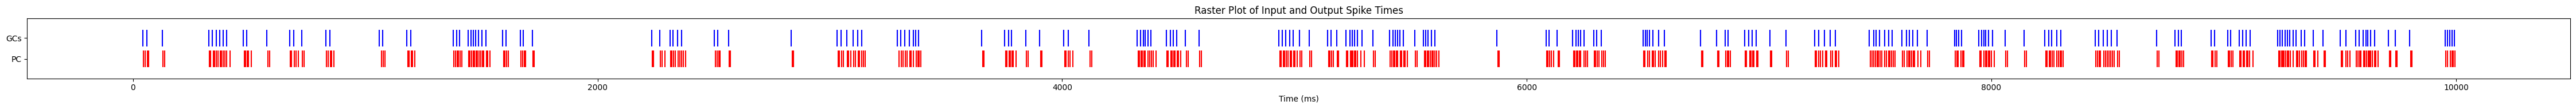

In [99]:
Plot_SpikeTrain(GC_sptimes,PC_sptimes,'GC','PC')

firing rate of PC neuron:130.4


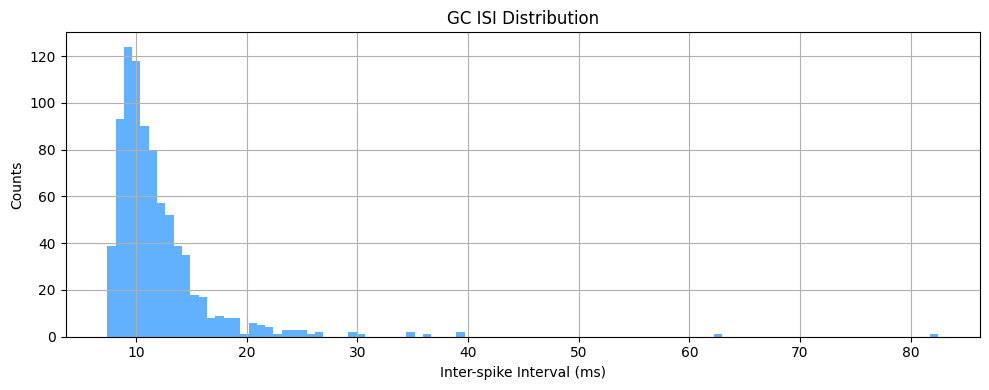

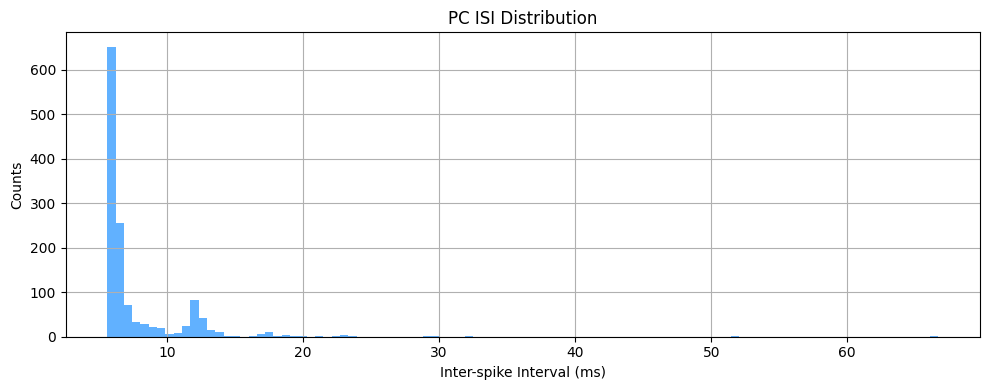

In [18]:
print(f"firing rate of PC neuron:{len(PC_sptimes)/duration}")
plot_isi(GC_isi,'GC',100)
plot_isi(PC_isi,'PC',100)  #尽量让这个分布密度密一些，峰值更大一些，峰更靠右一些

# CbX -> DCN

create three neurons with renewal process ISI <br>
A single neuron in the deep cerebellar nuclei (DCN) receives input from a population of approximately 40 Purkinje cells (Kathellen Cullen)<br>
A single PC is estimated to innervate approximately 30–40 DCN neurons and in turn, each DCN neuron, receives projections from about 600–900 PC (Chan-Palay, 1973a ; Mezey et al., 1977 ; Palkovits et al., 1977 ) <br>但并不是所有的PC都会发放

可以看到Syt2KO CbX neuron ISI 呈现gamma 分布 <br>
Gamma分布 神经元能提供规则、有时序结构的 volley，建议25个，α=3 的 Gamma 分布，每 100ms 时间窗内发 1 spike<br>
Gamma分布均值建议10–20ms，平均发放率 50–100Hz，适合产生 volley<br>
Exponential分布 神经元提供不规则背景噪声，可能干扰，也可能偶尔辅助，建议5个，λ=10–20Hz<br>
每 100ms 左右产生一次整合性高的 EPSP volley → 引发 burst<br>
剩下时间仅靠 Exponential spike 无法激发 neuron → 保持 50ms silent<br>

1. Input: Synchronus Syt2ko Projection PC spike train and normal PC spike train

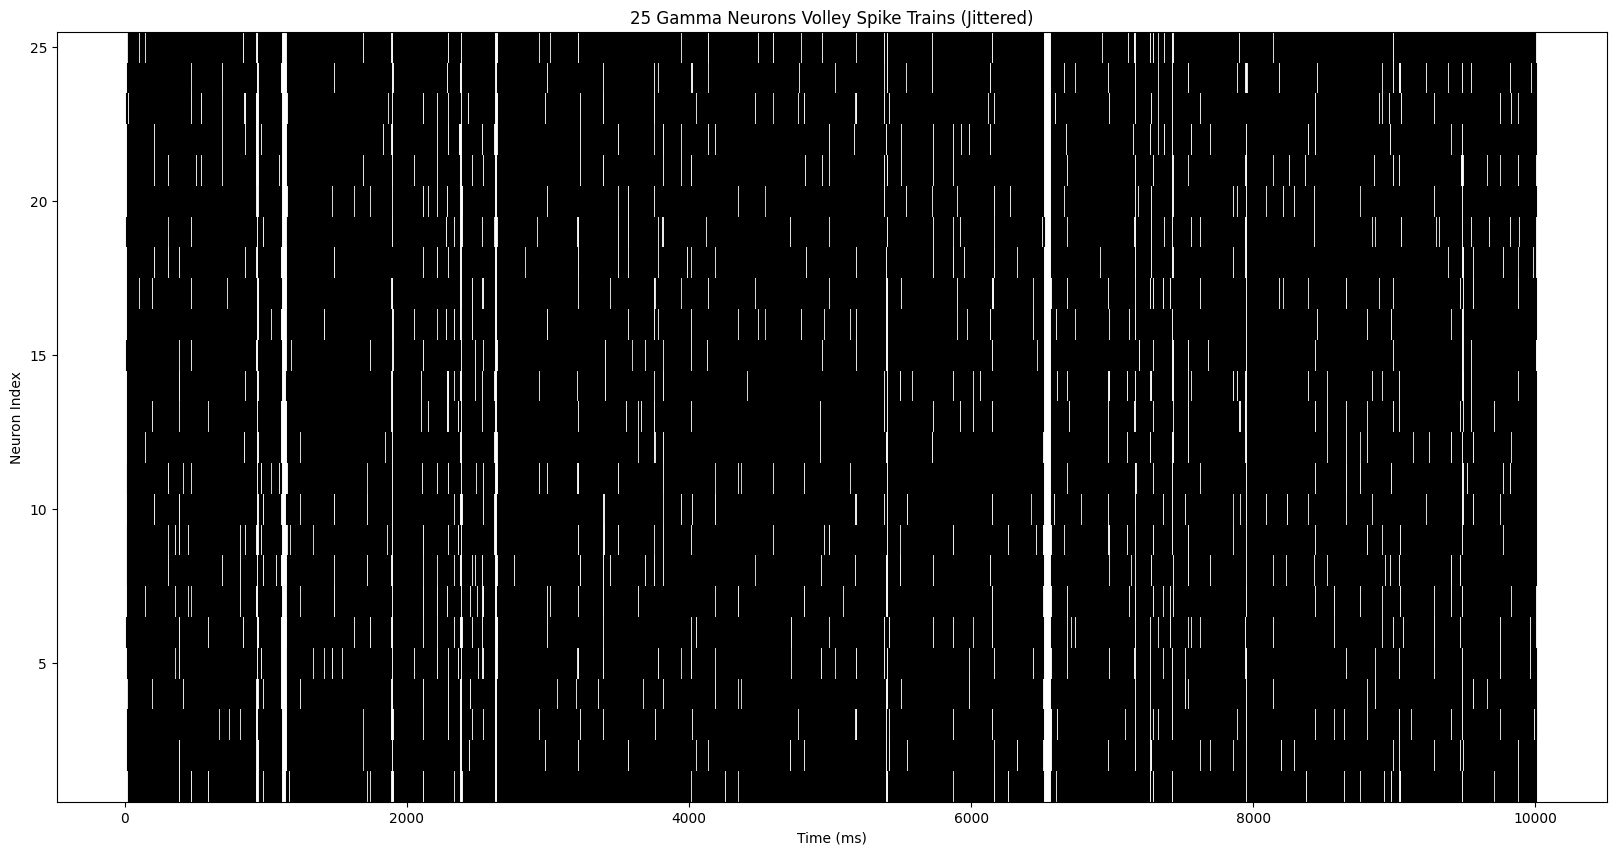

In [24]:
PC_syt2ko_proj_num = 25  # synchrony neuron number syt2ko
PC_normal_proj_num = 5   # synchrony neuron number 正常神经元 

# syt2ko : normal = 9 : 1 出现分立的gamma分布 syt2ko : normal = 15 : 3 出现多个分立峰 oscillation 
PC_neuron_num = PC_syt2ko_proj_num + PC_normal_proj_num
jitter_window = 10  # ms

# 生成 spike trains：25个 list，每个神经元一个 spike time 数组
volley_spike_trains = []

all_events = []  # 格式：(spike_time, neuron_id)

for i in range(PC_syt2ko_proj_num):
    # 对于每个神经元，在每个 gamma spike 时间 t 加入一个 [0,10]ms 的 jitter
    jittered_spike_times = PC_sptimes + np.random.uniform(0, jitter_window, size=PC_sptimes.shape)
    volley_spike_trains.append(np.sort(jittered_spike_times))
    # 为当前神经元的每个发放时间添加事件
    for t in jittered_spike_times:
        all_events.append((t, i))  # 记录(时间, 神经元ID)

# 生成正常神经元的发放事件
for j in range(PC_normal_proj_num):
    CbX_normal_sptimes, _ = Poisson_sptrain(fr = 10)  # 忽略ISI数据
    neuron_id = j + PC_syt2ko_proj_num  
    
    # 为当前神经元的每个发放时间添加事件
    for t in CbX_normal_sptimes:
        all_events.append((t, neuron_id))

# 按发放时间排序
all_events.sort(key=lambda x: x[0])  # 根据spike_time排序

# 提取排序后的发放时间和对应神经元ID
DCN_spike_times = [event[0] for event in all_events]
DCN_spike_cluster = [event[1] for event in all_events]

# 可视化 raster plot
plt.figure(figsize=(20, 10))
for i, train in enumerate(volley_spike_trains):
    plt.vlines(train, i + 0.5, i + 1.5, color='black')

plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('25 Gamma Neurons Volley Spike Trains (Jittered)')
plt.ylim(0.5, PC_syt2ko_proj_num + 0.5)
plt.show()

Optional: 生成独立的CbX Syt2KO/正常神经元的spike train

In [25]:
syt2ko_num = 12  # synchrony neuron number syt2ko
normal_num = 5   # synchrony neuron number 正常神经元 

# syt2ko : normal = 9 : 1 出现分立的gamma分布 syt2ko : normal = 15 : 3 出现多个分立峰 oscillation 
neuron_num = syt2ko_num + normal_num

# 初始化存放所有发放事件的列表
all_events = []  # 格式：(spike_time, neuron_id)

# 生成syt2ko神经元的发放事件
for i in range(syt2ko_num):
    VN_sptimes, _ = Poisson_sptrain(fr = 60)  # 忽略ISI数据
    CbX_PostV = run_a_net(VN_CbX_Net(sptimes = VN_sptimes, E=0.))
    CbX_PostV_value = CbX_PostV.value  # 获取 Array 对象
    CbX_PostV_flat = CbX_PostV_value.flatten()  # 平铺成一维数组
    CbX_Syt2ko_sptimes = find_trig_spike_time(CbX_PostV_flat)  # unit ms

    # 为当前神经元的每个发放时间添加事件
    for t in CbX_Syt2ko_sptimes:
        all_events.append((t, i))  # 记录(时间, 神经元ID)

# 生成正常神经元的发放事件
for j in range(normal_num):
    CbX_normal_sptimes, _ = Poisson_sptrain(fr = 10)  # 忽略ISI数据
    neuron_id = j + syt2ko_num  
    
    # 为当前神经元的每个发放时间添加事件
    for t in CbX_normal_sptimes:
        all_events.append((t, neuron_id))

# 按发放时间排序
all_events.sort(key=lambda x: x[0])  # 根据spike_time排序

# 提取排序后的发放时间和对应神经元ID
spike_times = [event[0] for event in all_events]
spike_cluster = [event[1] for event in all_events]

NameError: name 'VN_CbX_Net' is not defined

2. Network: Purkinje cell -> Deep cerebellar neucleus neuron

In [26]:
class PC_DCN_Net(bp.DynSysGroup):
  def __init__(self, E=0.):
    super().__init__()
    # times is spike times of each spike, indices is unit id of each spike
    self.pre = bp.dyn.SpikeTimeGroup(PC_neuron_num, times=DCN_spike_times, indices=DCN_spike_cluster)  # spike train input
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))

    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., g_max=1., 
                                 tau_decay=5., tau_rise=1., E=E)             
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    
    # monitor the following variables
    conductance = self.syn.proj.refs['syn'].g
    current = self.post.sum_inputs(self.post.V)
    return conductance, current, self.post.V

3. Output: DCN spike times

In [27]:
DCN_PostV = run_a_net(PC_DCN_Net(E=-35.)) # all neurons projecting from the cerebellar cortex to the deep cerebellar nuclei are inhibitory neurons
DCN_PostV_value = DCN_PostV.value  # 获取 Array 对象
DCN_PostV_flat = DCN_PostV_value.flatten()  # 平铺成一维数组
DCN_sptimes = find_trig_spike_time(DCN_PostV_flat)  # unit ms
DCN_isi = np.diff(DCN_sptimes)

/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPreMg2 is deprecated. Use brainpy.dyn.FullProjAlignPreDSMg instead.
  _deprecate(message)
  0%|          | 0/100000 [00:00<?, ?it/s]/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/jax/extend/linear_util.py:38: DeprecationWarning: linear_util.wrap_init is missing a DebugInfo object. This behavior is deprecated, use api_util.debug_info() to construct a proper DebugInfo object and propagate it to this function. See https://github.com/jax-ml/jax/issues/26480 for more details.
  debug_info = debug_info or _missing_debug_info("linear_util.wrap_init")
/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/brainpy/_src/mixin.py:489: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', 

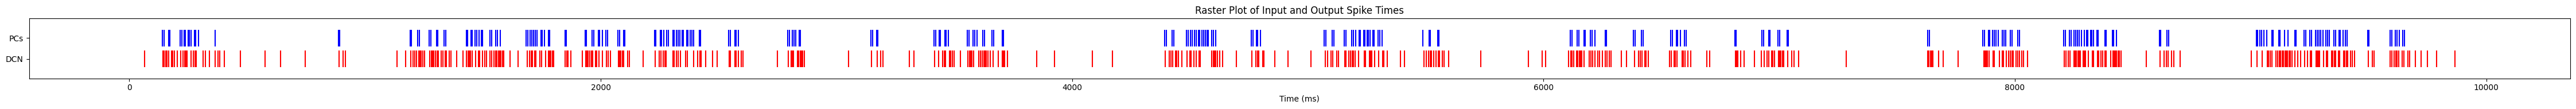

In [153]:
Plot_SpikeTrain(PC_sptimes,DCN_sptimes,'PC','DCN')

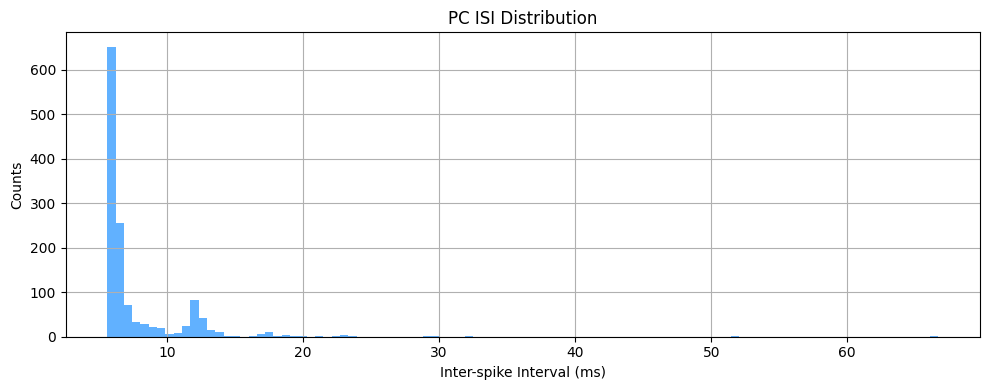

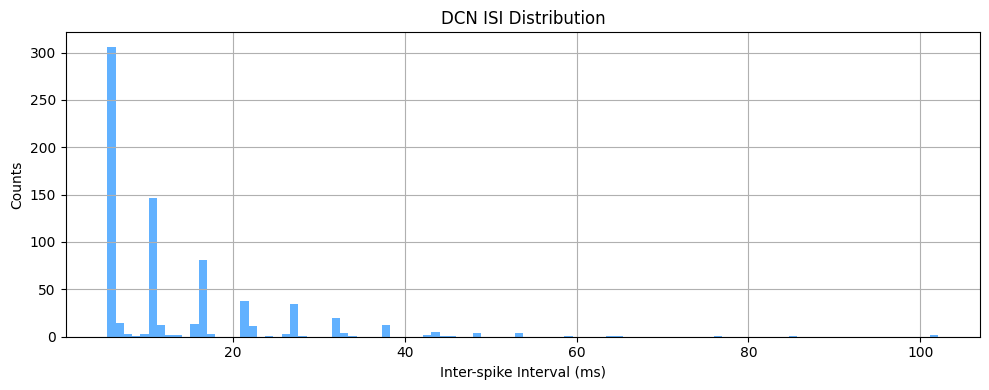

In [28]:
plot_isi(PC_isi,'PC',150)
plot_isi(DCN_isi,'DCN',150)

# DCN inner network

In [ ]:
DCN_inner_neunum = 2
DCN_inner_sptimes = np.repeat(DCN_sptimes, DCN_inner_neunum)
DCN_inner_indices = list(range(DCN_inner_neunum)) * len(DCN_sptimes)

In [ ]:
class SimpleNet6(bp.DynSysGroup):
  def __init__(self, E=0.):
    super().__init__()
    
    self.pre = bp.dyn.SpikeTimeGroup(DCN_inner_neunum, times=DCN_inner_sptimes, indices=DCN_inner_indices)  # spike train input
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))

    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., g_max=1., 
                                 tau_decay=5., tau_rise=1., E=E)  
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    
    # monitor the following variables
    conductance = self.syn.proj.refs['syn'].g
    current = self.post.sum_inputs(self.post.V)
    return conductance, current, self.post.V

Deep cerebellar nuclei (DCN) have projection neurons that contribute to the cerebellum's output <br>
These projections can be both excitatory and inhibitory

In [ ]:
PostV3 = run_a_net(SimpleNet6(E=0.))
value_array3 = PostV3.value  # 获取 Array 对象
flattened_arr3 = value_array3.flatten()  # 平铺成一维数组
np.set_printoptions(threshold=np.inf)

output_sptimes3 = find_trig_spike_time(flattened_arr3)  # unit ms
output_isi3 = np.diff(output_sptimes3)

In [ ]:
plt.figure(figsize=(60, 2))
plt.eventplot([DCN_sptimes, output_sptimes3], colors=['b', 'r'], lineoffsets=[2, 1], linelengths=0.8)
plt.yticks([1, 2], ['Output', 'Input'])
plt.xlabel('Time (ms)')
plt.title('Raster Plot of Input and Output Spike Times')
plt.tight_layout()
plt.savefig('/home/zhangyuhao/Desktop/Result/ET/Modeling/Raster.png', transparent=True, dpi=500)

In [ ]:
cutoff_distr = 100
def plot_isi(isi,name):
    isi = isi[(isi > 0.001) & (isi <= cutoff_distr)]
    plt.figure(figsize=(10, 4))
    plt.hist(isi, bins=100, color='dodgerblue', alpha=0.7)
    plt.xlabel('Inter-spike Interval (ms)')
    plt.ylabel('Counts')
    plt.title(f'{name} ISI Distribution')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_isi(DCN_isi,'input',100)
plot_isi(output_isi3,'output',100)

## Problem of Phenomenological Synaptic Models

A significant limitation of the simple waveform description of synaptic conductance is that it does not capture the actual behavior seen at many synapses when trains of action potentials arrive. 

A new release of neurotransmitter soon after a previous release should not be expected to contribute as much to the postsynaptic conductance due to saturation of postsynaptic receptors by previously released transmitter and the fact that some receptors will already be open.

In [ ]:
class SimpleNet5(bp.DynSysGroup):
  def __init__(self, freqs=10.):
    super().__init__()
    self.pre = bp.dyn.PoissonGroup(1, freqs=freqs)
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., g_max=1., 
                                 tau_decay=5., tau_rise=1., E=0.)
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    return self.syn.proj.refs['syn'].g, self.post.V

In [ ]:
def compare(freqs):
  fig, _ = bp.visualize.get_figure(1, 1, 4.5, 6.)
  for freq in freqs:
    net = SimpleNet5(freqs=freq)
    indices = np.arange(1000)  # 100 ms
    conductances, potentials = bm.for_loop(net.step_run, indices, progress_bar=True)
    plt.plot(indices * bm.get_dt(), conductances, label=f'{freq} Hz')
  plt.legend()
  plt.ylabel('g')
  plt.show()


compare([10., 100., 1000., 8000.])